In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Step 2: Load the Dataset
df = pd.read_csv("/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt",sep='\t') 
df.head()

,"hi, how are you doing?",i'm fine. how about yourself?
0,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
1,i'm pretty good. thanks for asking.,no problem. so how have you been?
2,no problem. so how have you been?,i've been great. what about you?
3,i've been great. what about you?,i've been good. i'm in school right now.
4,i've been good. i'm in school right now.,what school do you go to?


In [5]:
df.tail()

,"hi, how are you doing?",i'm fine. how about yourself?
3719,that's a good question. maybe it's not old age.,are you right-handed?
3720,are you right-handed?,yes. all my life.
3721,yes. all my life.,you're wearing out your right hand. stop using...
3722,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.
3723,but i do all my writing with my right hand.,start typing instead. that way your left hand ...


In [6]:
# Shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (3724, 2)


In [7]:
# Column names
print("Columns in the dataset:", df.columns.tolist())

Columns in the dataset: ['hi, how are you doing?', "i'm fine. how about yourself?"]


In [8]:
# Assign column names manually
df.columns = ['question', 'answer']

In [9]:
df.head()

,question,answer
0,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
1,i'm pretty good. thanks for asking.,no problem. so how have you been?
2,no problem. so how have you been?,i've been great. what about you?
3,i've been great. what about you?,i've been good. i'm in school right now.
4,i've been good. i'm in school right now.,what school do you go to?


In [10]:
df.sample(5)

,question,answer
3219,what's the matter with yours?,it's six years old.
339,i made sure to be in line to see it the first ...,i couldn't keep from laughing throughout the w...
395,what are you doing this weekend?,i'm going to the movies with a friend. how abo...
3000,i got a d in college chemistry.,"well, a d is better than an f."
1539,i don't like our flag.,what's the matter with it?


In [11]:
# Data types and null info
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3724 entries, 0 to 3723
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  3724 non-null   object
 1   answer    3724 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB
None


In [12]:
# Summary statistics
print("\nDescriptive Stats:")
print(df.describe(include='all'))


Descriptive Stats:
                 question             answer
count                3724               3724
unique               3509               3511
top     what do you mean?  what do you mean?
freq                   22                 22


In [13]:
# Check duplicate rows
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 1


In [14]:
# Total missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
question    0
answer      0
dtype: int64


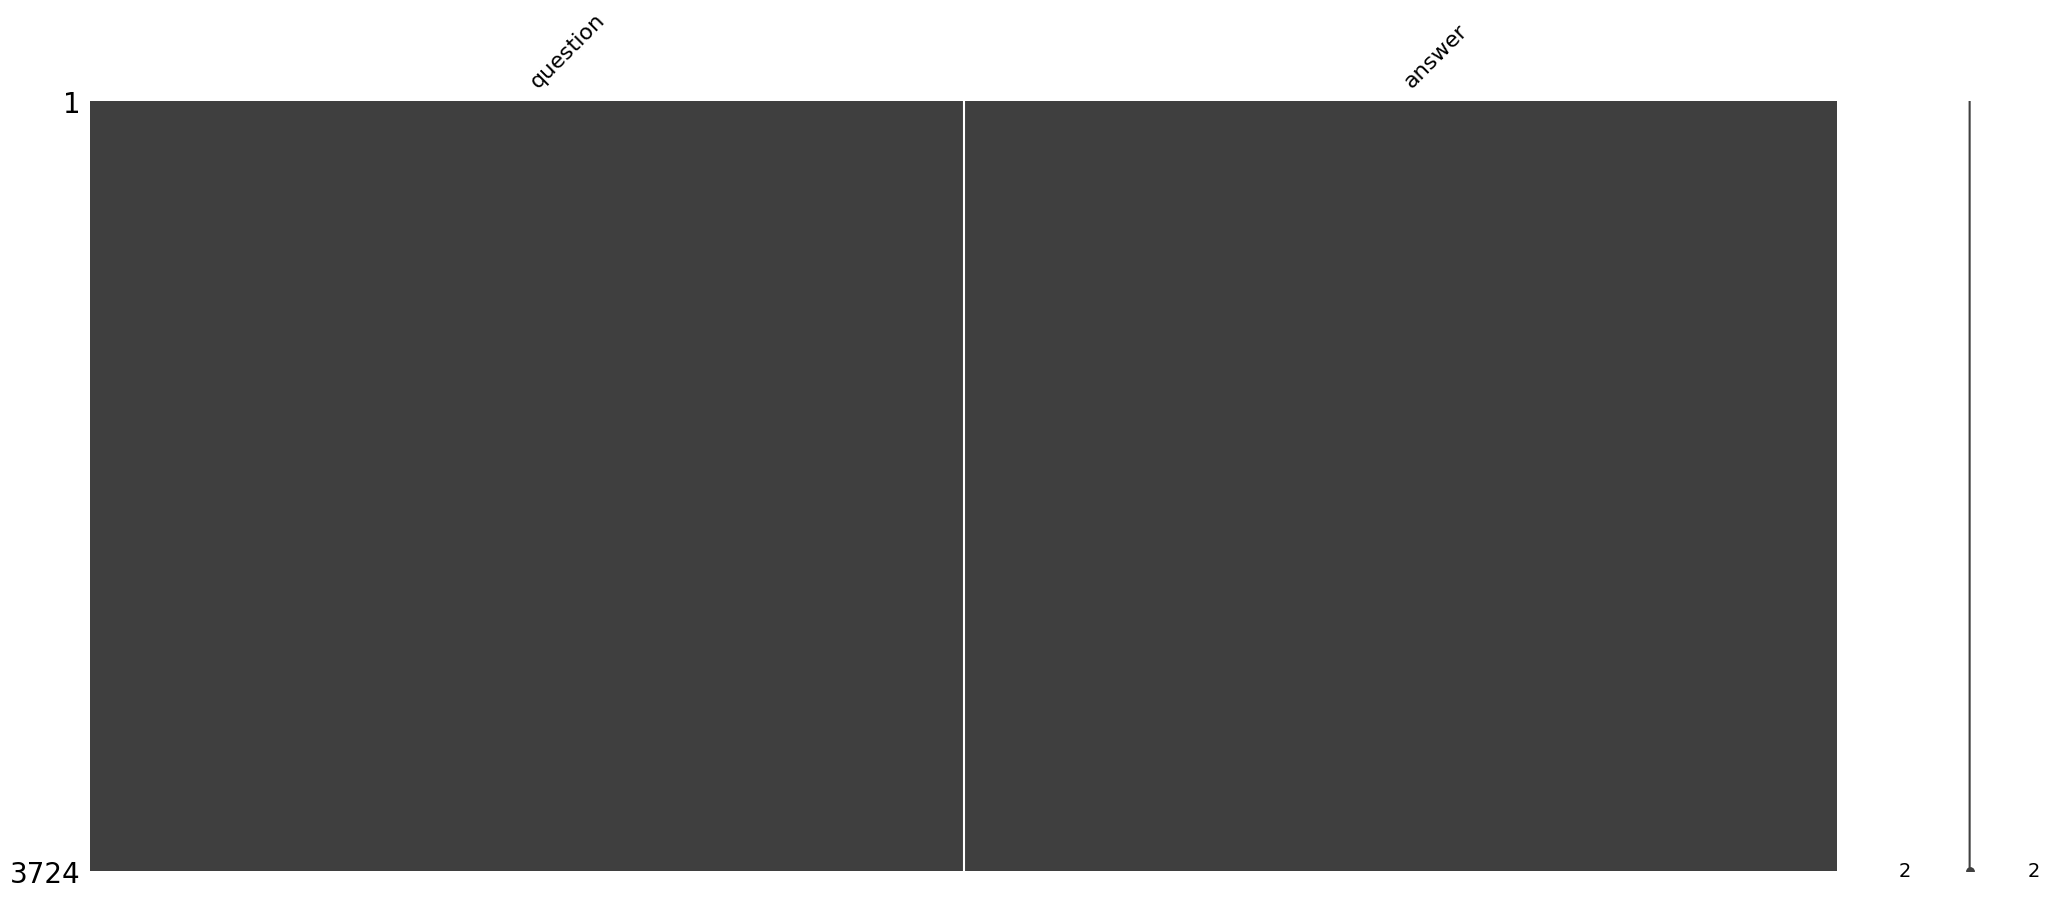

In [15]:
# Visualizing missing data
msno.matrix(df)
plt.show()

## Cleaning the Dataset

In [16]:
#dictionary to expand common contractions
contractions = {
    "i'm": "i am","you're": "you are","he's": "he is","she's": "she is","it's": "it is","we're": "we are","they're": "they are","i've": "i have",
    "you've": "you have","we've": "we have","they've": "they have","i'll": "i will","you'll": "you will","he'll": "he will","she'll": "she will",
    "it'll": "it will","we'll": "we will","they'll": "they will","i'd": "i would","you'd": "you would","he'd": "he would","she'd": "she would",
    "we'd": "we would","they'd": "they would","can't": "cannot","won't": "will not","don't": "do not","doesn't": "does not","didn't": "did not",
    "isn't": "is not","aren't": "are not","wasn't": "was not","weren't": "were not","wouldn't": "would not","shouldn't": "should not","couldn't": "could not",
    "mustn't": "must not","haven't": "have not","hasn't": "has not","hadn't": "had not","mightn't": "might not","needn't": "need not",
    "shan't": "shall not","let's": "let us","who's": "who is","what's": "what is","where's": "where is","when's": "when is","why's": "why is",
    "how's": "how is","there's": "there is","here's": "here is","that'll": "that will","who'll": "who will","what'll": "what will","y'all": "you all","o'clock": "of the clock",
    "ma'am": "madam","n't": " not","'re": " are","'s": " is","'d": " would","'ll": " will","'t": " not","'ve": " have","'m": " am"
}


# Define a cleaning function
def clean_text(text):
    text = str(text).lower()                              # Lowercase
    
    for contraction, expanded in contractions.items():    # Expand contractions
        text = text.replace(contraction, expanded)
        
    text = re.sub(r'[^a-zA-Z\s]', '', text)               # Remove punctuation
    
    text = re.sub(r'\s+', ' ', text).strip()              # Remove extra spaces
    
    return text

# Apply it to text columns (assuming 'questions' and 'answers')
df['question_cleaned'] = df['question'].apply(clean_text)
df['answer_cleaned'] = df['answer'].apply(clean_text)

df[['question', 'question_cleaned', 'answer', 'answer_cleaned']].head()


,question,question_cleaned,answer,answer_cleaned
0,i'm fine. how about yourself?,i am fine how about yourself,i'm pretty good. thanks for asking.,i am pretty good thanks for asking
1,i'm pretty good. thanks for asking.,i am pretty good thanks for asking,no problem. so how have you been?,no problem so how have you been
2,no problem. so how have you been?,no problem so how have you been,i've been great. what about you?,i have been great what about you
3,i've been great. what about you?,i have been great what about you,i've been good. i'm in school right now.,i have been good i am in school right now
4,i've been good. i'm in school right now.,i have been good i am in school right now,what school do you go to?,what school do you go to


## Visualization

In [17]:
# Add length columns
df['question_len'] = df['question'].apply(lambda x: len(str(x).split()))
df['answer_len'] = df['answer'].apply(lambda x: len(str(x).split()))

# Add length columns
df['question_cleaned_len'] = df['question_cleaned'].apply(lambda x: len(str(x).split()))
df['answer_cleaned_len'] = df['answer_cleaned'].apply(lambda x: len(str(x).split()))

## Length of the sentence before cleaning

In [18]:
print(df['question_len'])

0        5
1        6
2        7
3        6
4        8
        ..
3719     9
3720     3
3721     4
3722    11
3723    10
Name: question_len, Length: 3724, dtype: int64


In [19]:
print(df['answer_len'])

0        6
1        7
2        6
3        8
4        6
        ..
3719     3
3720     4
3721    11
3722    10
3723    13
Name: answer_len, Length: 3724, dtype: int64


## Length of the sentence after cleaning

In [20]:
print(df['question_cleaned_len'])

0        6
1        7
2        7
3        7
4       10
        ..
3719    11
3720     3
3721     4
3722    12
3723    10
Name: question_cleaned_len, Length: 3724, dtype: int64


In [21]:
print(df['answer_cleaned_len'])

0        7
1        7
2        7
3       10
4        6
        ..
3719     3
3720     4
3721    12
3722    10
3723    13
Name: answer_cleaned_len, Length: 3724, dtype: int64


## Plotting the Histplot for before cleaning the dataset

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


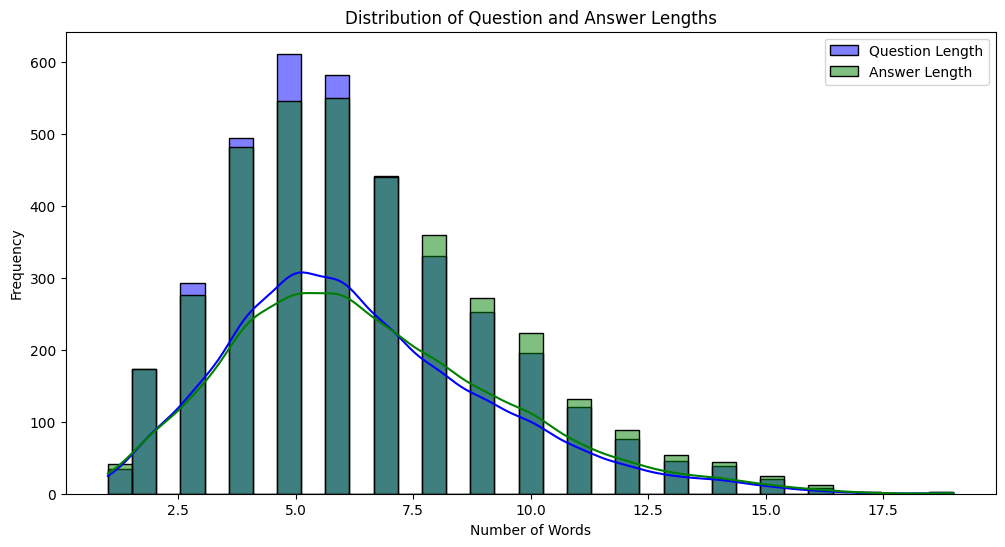

In [22]:
# Plotting distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['question_len'], kde=True, color='blue', label='Question Length')
sns.histplot(df['answer_len'], kde=True, color='green', label='Answer Length')
plt.legend()
plt.title("Distribution of Question and Answer Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## Plotting the histplot after cleaning the dataset

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


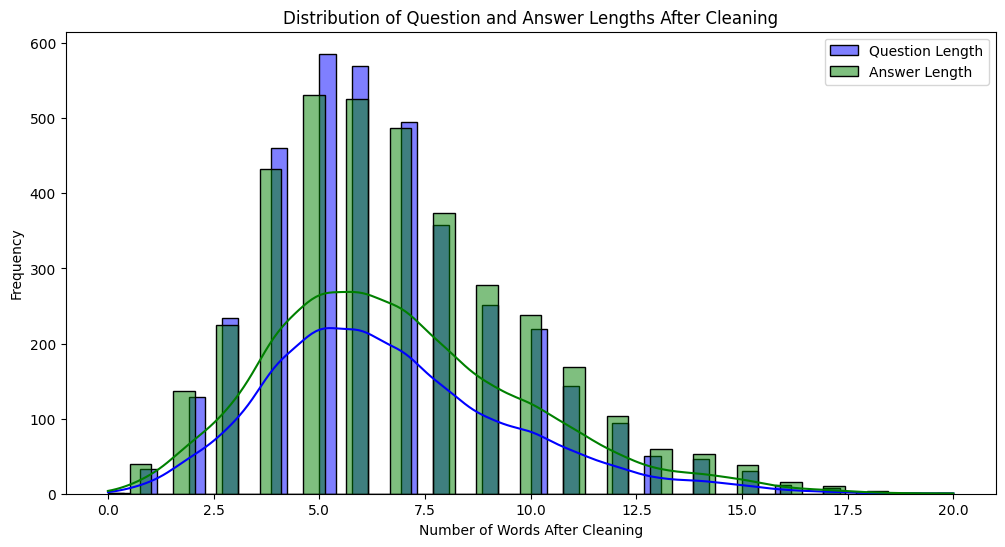

In [23]:
# Plotting distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['question_cleaned_len'], kde=True, color='blue', label='Question Length')
sns.histplot(df['answer_cleaned_len'], kde=True, color='green', label='Answer Length')
plt.legend()
plt.title("Distribution of Question and Answer Lengths After Cleaning")
plt.xlabel("Number of Words After Cleaning")
plt.ylabel("Frequency")
plt.show()

## Distribution of Dataset lengths before cleaning

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


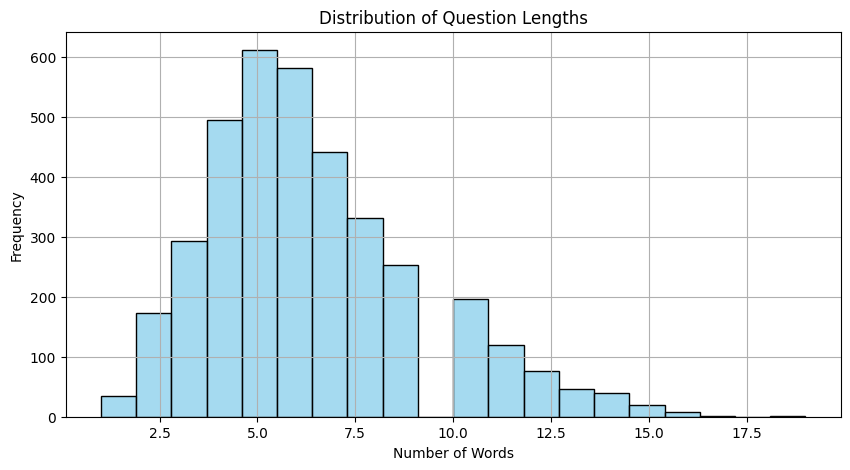

In [24]:
# 1. Distribution of Question Lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['question'].apply(lambda x: len(str(x).split())), bins=20, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


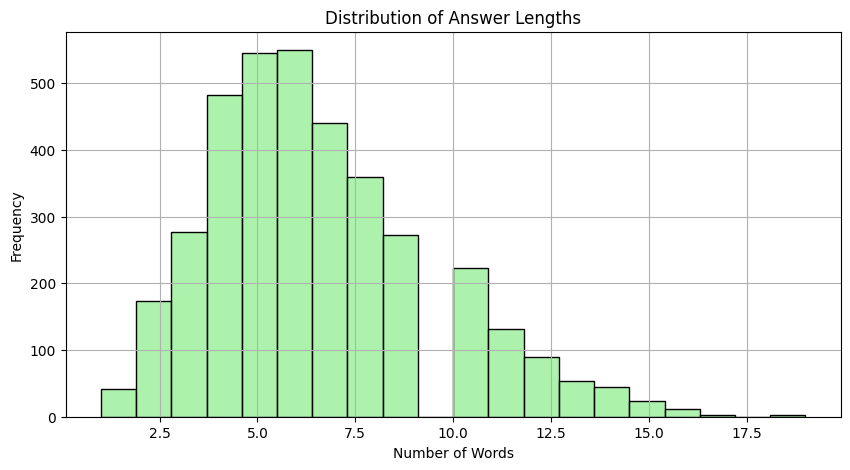

In [25]:
# 2. Distribution of Answer Lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['answer'].apply(lambda x: len(str(x).split())), bins=20, color='lightgreen')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Distribution of Dataset lengths after cleaning

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


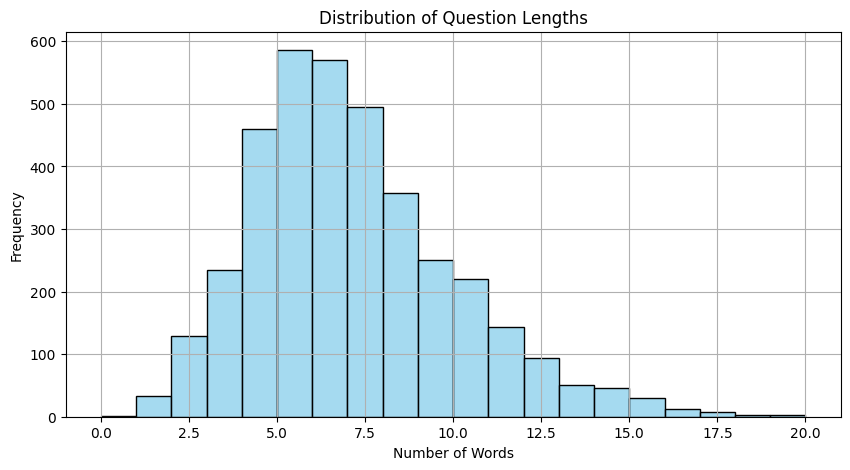

In [26]:
# 1. Distribution of Question Lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['question_cleaned'].apply(lambda x: len(str(x).split())), bins=20, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


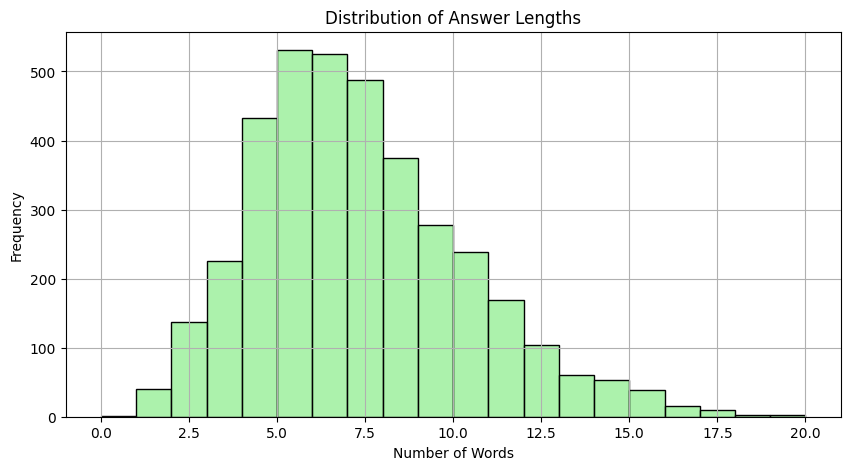

In [27]:
# 2. Distribution of Answer Lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['answer_cleaned'].apply(lambda x: len(str(x).split())), bins=20, color='lightgreen')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Creating the word cloud for the dataset after cleaning

In [28]:
# Combine all text for word cloud
question_text = " ".join(df['question_cleaned'].dropna().tolist())
answer_text = " ".join(df['answer_cleaned'].dropna().tolist())

In [ ]:
#print(question_text)

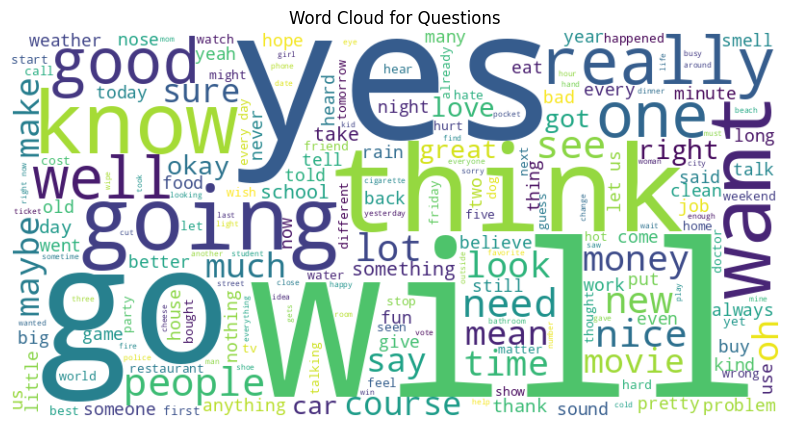

In [29]:
# Word Cloud for Questions
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Questions")
plt.show()

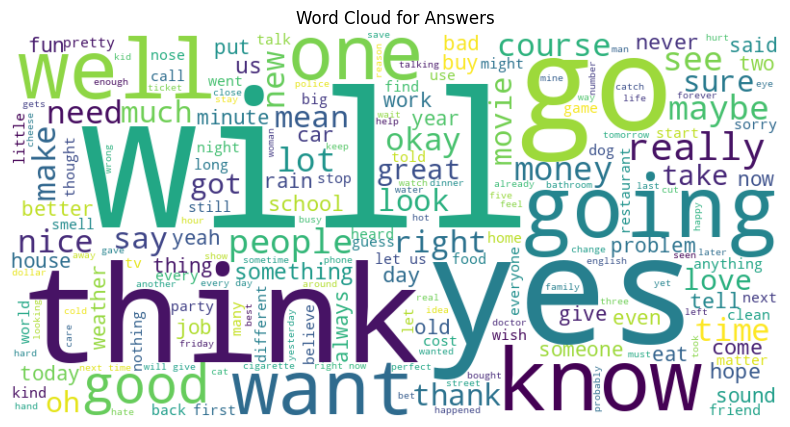

In [30]:
# Word Cloud for Answers
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(answer_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Answers")
plt.show()

## Applying Tokenization

In [31]:
# Simple whitespace tokenizer
def tokenize_text(text):
    return text.split()

# Apply tokenization to cleaned questions and answers
df['question_tokens'] = df['question_cleaned'].apply(tokenize_text)
df['answer_tokens'] = df['answer_cleaned'].apply(tokenize_text)

# Display a sample
df[['question_cleaned', 'question_tokens', 'answer_cleaned', 'answer_tokens']].head()

,question_cleaned,question_tokens,answer_cleaned,answer_tokens
0,i am fine how about yourself,"[i, am, fine, how, about, yourself]",i am pretty good thanks for asking,"[i, am, pretty, good, thanks, for, asking]"
1,i am pretty good thanks for asking,"[i, am, pretty, good, thanks, for, asking]",no problem so how have you been,"[no, problem, so, how, have, you, been]"
2,no problem so how have you been,"[no, problem, so, how, have, you, been]",i have been great what about you,"[i, have, been, great, what, about, you]"
3,i have been great what about you,"[i, have, been, great, what, about, you]",i have been good i am in school right now,"[i, have, been, good, i, am, in, school, right..."
4,i have been good i am in school right now,"[i, have, been, good, i, am, in, school, right...",what school do you go to,"[what, school, do, you, go, to]"


## Count tokens per row

In [32]:
df['question_length'] = df['question_tokens'].apply(len)
df['answer_length'] = df['answer_tokens'].apply(len)

## Applying Sentiment Analysis

### Step 1: Install and import required libraries

In [33]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

### Step 2: Initialize the Sentiment Analyzer

In [35]:
analyzer = SentimentIntensityAnalyzer()

### Step 3: Apply sentiment analysis on cleaned questions and answers

In [36]:
# Function to classify sentiment
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)

# Apply sentiment analysis
df['question_sentiment'] = df['question_cleaned'].apply(get_sentiment_score)
df['answer_sentiment'] = df['answer_cleaned'].apply(get_sentiment_score)

### Step 4: Extract sentiment scores into separate columns

In [37]:
# Split sentiment dict into separate columns
df['q_sent_neg'] = df['question_sentiment'].apply(lambda x: x['neg'])
df['q_sent_neu'] = df['question_sentiment'].apply(lambda x: x['neu'])
df['q_sent_pos'] = df['question_sentiment'].apply(lambda x: x['pos'])
df['q_sent_compound'] = df['question_sentiment'].apply(lambda x: x['compound'])

df['a_sent_neg'] = df['answer_sentiment'].apply(lambda x: x['neg'])
df['a_sent_neu'] = df['answer_sentiment'].apply(lambda x: x['neu'])
df['a_sent_pos'] = df['answer_sentiment'].apply(lambda x: x['pos'])
df['a_sent_compound'] = df['answer_sentiment'].apply(lambda x: x['compound'])


### Step 5: Classify sentiment (Positive, Negative, Neutral)

In [38]:
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['q_sentiment_label'] = df['q_sent_compound'].apply(classify_sentiment)
df['a_sentiment_label'] = df['a_sent_compound'].apply(classify_sentiment)


### Step 6: Visualize sentiment distribution

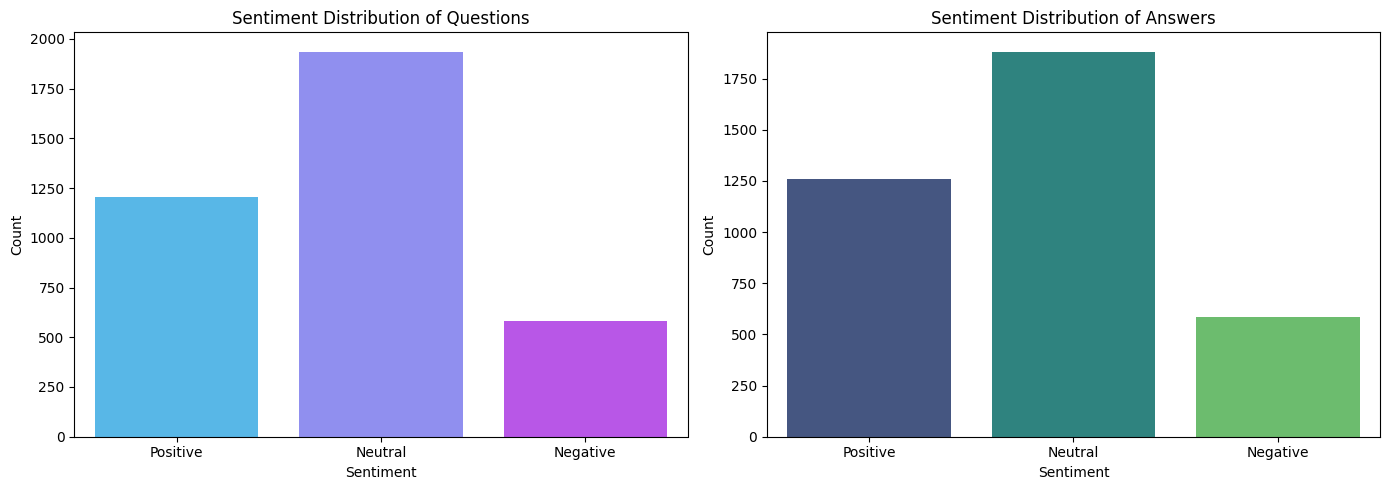

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Questions
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='q_sentiment_label', palette='cool')
plt.title("Sentiment Distribution of Questions")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Answers
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='a_sentiment_label', palette='viridis')
plt.title("Sentiment Distribution of Answers")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


## Building a Chatbot Response Analyzer

### Step 1: Install and Import Required Libraries

In [40]:
pip install nltk textblob

Note: you may need to restart the kernel to use updated packages.


In [51]:
 import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')



nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

### Step 3: Define Helper Functions

In [42]:
#A. Keyword Overlap Score

def keyword_overlap(q, a):
    q_tokens = set(word_tokenize(q.lower())) - set(stopwords.words('english'))
    a_tokens = set(word_tokenize(a.lower())) - set(stopwords.words('english'))
    if not q_tokens:
        return 0
    return len(q_tokens & a_tokens) / len(q_tokens)


In [43]:
#B. Sentiment Comparison

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"



In [44]:
#C. Verb Check

def has_verb(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return any(tag.startswith('VB') for word, tag in pos_tags)


In [45]:
#D. Length Check
def response_length_ok(text, min_words=3, max_words=50):
    return min_words <= len(word_tokenize(text)) <= max_words


### ChatBot Analyzer

In [47]:
def chatbot_analyzer(question, answer):
    analysis = {}

    # Rule 1: Keyword Overlap
    analysis['keyword_overlap'] = keyword_overlap(question, answer)

    # Rule 2: Sentiment Match
    analysis['question_sentiment'] = get_sentiment(question)
    analysis['answer_sentiment'] = get_sentiment(answer)

    # Rule 3: Verb Presence
    analysis['answer_has_verb'] = has_verb(answer)

    # Rule 4: Length Check
    analysis['response_length_ok'] = response_length_ok(answer)

    # Summary Judgment
    analysis['is_acceptable'] = (
        analysis['keyword_overlap'] >= 0.3 and
        analysis['answer_has_verb'] and
        analysis['response_length_ok']
    )

    return analysis


In [48]:
def chat_and_evaluate(chatbot_function):
    while True:
        question = input("You: ")
        if question.lower() in ['exit', 'quit']:
            break
        answer = chatbot_function(question)
        print("Chatbot:", answer)

        analysis = chatbot_analyzer(question, answer)
        print("\n--- Response Analysis ---")
        for k, v in analysis.items():
            print(f"{k}: {v}")
        print("-------------------------\n")


In [49]:
def dummy_chatbot(question):
    # Replace with real model or logic
    if "hello" in question.lower():
        return "Hi I am fine!"
    return "I'm not sure how to respond to that."


In [52]:
chat_and_evaluate(dummy_chatbot)


KeyboardInterrupt: Interrupted by user

In [53]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')  # if using stopwords in other parts

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))


In [56]:
def keyword_overlap(q, a):
    q_words = set(word_tokenize(q.lower())) - stop_words
    a_words = set(word_tokenize(a.lower())) - stop_words
    return len(q_words.intersection(a_words)) / max(len(q_words.union(a_words)), 1)


In [57]:
def get_sentiment_rule(text):
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'


In [58]:
from nltk.tokenize import word_tokenize

def pos_check(text):
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    if any(tag.startswith('VB') for word, tag in tags):
        return 'has_verb'
    return 'no_verb'


In [59]:
df['q_sentiment_rule'] = df['question_cleaned'].apply(get_sentiment_rule)
df['a_sentiment_rule'] = df['answer_cleaned'].apply(get_sentiment_rule)
df['keyword_overlap_score'] = df.apply(lambda row: keyword_overlap(row['question_cleaned'], row['answer_cleaned']), axis=1)
df['answer_verb_check'] = df['answer_cleaned'].apply(pos_check)


In [60]:
def classify_response(row):
    if row['keyword_overlap_score'] < 0.2:
        return 'Low Relevance'
    if row['q_sentiment_rule'] != row['a_sentiment_rule']:
        return 'Sentiment Mismatch'
    if row['answer_verb_check'] == 'no_verb':
        return 'Incomplete Answer'
    return 'Good Response'

df['response_quality_rule_based'] = df.apply(classify_response, axis=1)


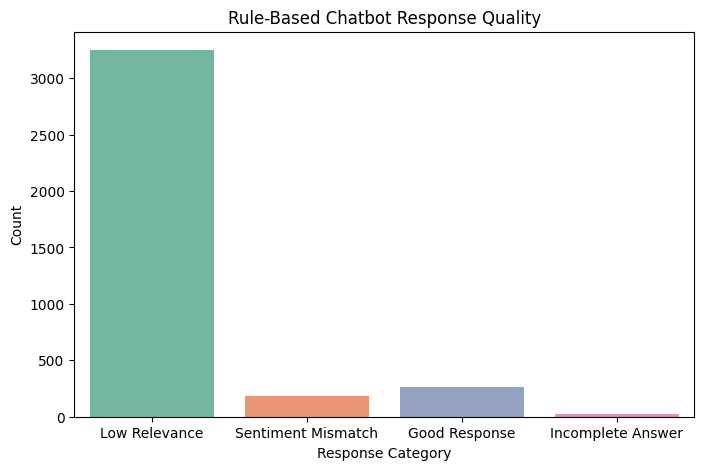

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='response_quality_rule_based', data=df, palette='Set2')
plt.title("Rule-Based Chatbot Response Quality")
plt.xlabel("Response Category")
plt.ylabel("Count")
plt.show()


In [62]:
df[['question_cleaned', 'answer_cleaned', 
    'keyword_overlap_score', 'q_sentiment_rule', 
    'a_sentiment_rule', 'answer_verb_check', 
    'response_quality_rule_based']].head(10)


,question_cleaned,answer_cleaned,keyword_overlap_score,q_sentiment_rule,a_sentiment_rule,answer_verb_check,response_quality_rule_based
0,i am fine how about yourself,i am pretty good thanks for asking,0.000000,positive,positive,has_verb,Low Relevance
1,i am pretty good thanks for asking,no problem so how have you been,0.000000,positive,negative,has_verb,Low Relevance
2,no problem so how have you been,i have been great what about you,0.000000,negative,positive,has_verb,Low Relevance
3,i have been great what about you,i have been good i am in school right now,0.000000,positive,positive,has_verb,Low Relevance
4,i have been good i am in school right now,what school do you go to,0.250000,positive,neutral,has_verb,Sentiment Mismatch
5,what school do you go to,i go to pcc,0.333333,neutral,neutral,has_verb,Good Response
6,i go to pcc,do you like it there,0.000000,neutral,positive,has_verb,Low Relevance
7,do you like it there,it is okay it is a really big campus,0.000000,positive,positive,has_verb,Low Relevance
8,it is okay it is a really big campus,good luck with school,0.000000,positive,positive,no_verb,Low Relevance
9,good luck with school,thank you very much,0.000000,positive,positive,no_verb,Low Relevance


In [63]:
# Show responses flagged as 'Low Relevance'
df[df['response_quality_rule_based'] == 'Low Relevance'][['question_cleaned', 'answer_cleaned']]


,question_cleaned,answer_cleaned
0,i am fine how about yourself,i am pretty good thanks for asking
1,i am pretty good thanks for asking,no problem so how have you been
2,no problem so how have you been,i have been great what about you
3,i have been great what about you,i have been good i am in school right now
6,i go to pcc,do you like it there
...,...,...
3715,it aches most of the time,what do you think it is
3719,that is a good question maybe it is not old age,are you righthanded
3720,are you righthanded,yes all my life
3721,yes all my life,you are wearing out your right hand stop using...


In [64]:
df['response_quality_rule_based'].value_counts()


response_quality_rule_based
Low Relevance         3250
Good Response          266
Sentiment Mismatch     180
Incomplete Answer       28
Name: count, dtype: int64

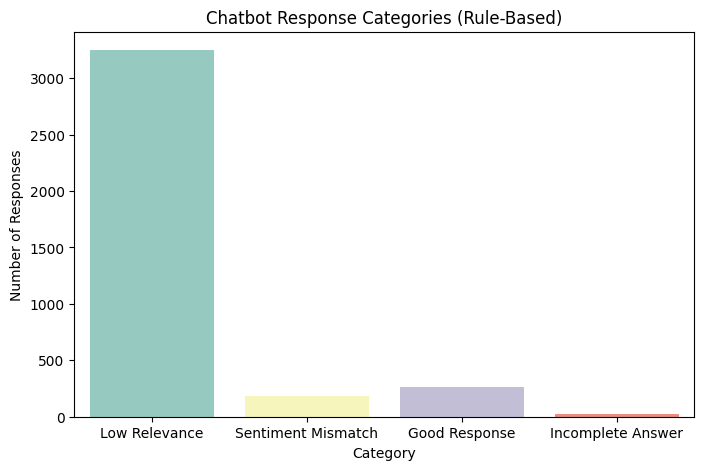

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='response_quality_rule_based', data=df, palette='Set3')
plt.title("Chatbot Response Categories (Rule-Based)")
plt.xlabel("Category")
plt.ylabel("Number of Responses")
plt.show()


In [ ]:
def rule_based_chatbot(user_input):
    import random
    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Preprocess user input (similar to how you cleaned your dataset)
    user_input_cleaned = preprocess_text(user_input)  # You already defined this earlier

    # Rule: Find the best matching response using keyword overlap
    best_score = 0
    best_response = "Sorry, I didn't understand that."
    
    for index, row in df.iterrows():
        question_words = set(row['questions_cleaned'].split())
        user_words = set(user_input_cleaned.split())
        overlap = len(question_words.intersection(user_words)) / max(len(question_words.union(user_words)), 1)
        
        if overlap > best_score:
            best_score = overlap
            best_response = row['answers_cleaned']
    
    # Rule: Optional sentiment check (not mandatory)
    user_sentiment = sia.polarity_scores(user_input_cleaned)['compound']
    response_sentiment = sia.polarity_scores(best_response)['compound']
    
    # Print output
    print(f"\n🤖 Chatbot: {best_response}")
    print(f"🧠 Match Score: {round(best_score, 2)} | Sentiment Match: {'Yes' if user_sentiment * response_sentiment > 0 else 'No'}")

# Chat loop
while True:
    user_input = input("👤 You: ")
    if user_input.lower() in ['exit', 'quit']:
        print("🤖 Chatbot: Goodbye!")
        break
    rule_based_chatbot(user_input)


👤 You:  hello


In [ ]:
import random

df['true_label'] = random.choices(['good', 'bad'], k=len(df))


In [ ]:
def rule_based_predict(row):
    if row['a_sentiment_rule'] == 'positive' and \
       row['keyword_overlap_score'] > 0.3 and \
       row['answer_verb_check'] == 'has_verb':
        return 'good'
    else:
        return 'bad'


In [ ]:
df['predicted_label'] = df.apply(rule_based_predict, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['true_label'], df['predicted_label'])
print("Rule-Based Chatbot Analyzer Accuracy:", accuracy)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df['true_label'], df['predicted_label']))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Combine question and answer as features
df['combined_text'] = df['question_cleaned'] + " " + df['answer_cleaned']

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['combined_text'])

# Labels (make sure you have true labels!)
y = df['true_label'].map({'good':1, 'bad':0})

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Prepare data
df['combined_text'] = df['question_cleaned'] + " " + df['answer_cleaned']

# Encode labels: 'good' -> 1, 'bad' -> 0
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['true_label'])  # 'good'=1, 'bad'=0

texts = df['combined_text'].values
labels = df['label_enc'].values

# 2. Tokenize text
MAX_NUM_WORDS = 10000  # vocab size
MAX_SEQ_LEN = 100      # max words per sequence

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# 3. Train test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# 4. Build LSTM model
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# 6. Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
import numpy as np

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
